In [49]:
pip install pandas sentence-transformers numpy scikit-learn seaborn matplotlib xgboost


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     |█████████████████████████████▌  | 273.7 MB 127.5 MB/s eta 0:00:01

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 297.1 MB 7.9 kB/s 
Note: you may need to restart the kernel to use updated packages.


In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn import preprocessing
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
train = pd.read_csv("training_data_telugu-hate.csv")
test = pd.read_csv("telugu-english-test-data-with-labels.csv",header=None)

In [73]:
# Extract column names from the first row
columns = test.iloc[0].tolist()
test = test[1:]  # Remove the first row containing column names
test.columns = columns  # Set the correct column names

# Separate the train sentences and labels into lists
train_sentences = train['Comments'].tolist()
train_labels = train['Label'].tolist()

# Separate the test sentences and labels into lists
test = test.dropna()  # Drop rows with missing values
test_sentences = test['Comments'].tolist()
test_labels = test['Label'].tolist()

# Label encoding
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)  # Use transform instead of fit_transform

# embeddings

In [74]:
trans_model = SentenceTransformer('bert-base-multilingual-cased')
train_embeddings = trans_model.encode(train_sentences)
test_embeddings = trans_model.encode(test_sentences)

No sentence-transformers model found with name bert-base-multilingual-cased. Creating a new one with MEAN pooling.


### class weights

In [75]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)


print("Class weights:")
for label, weight in zip(np.unique(train_labels), class_weights):
    print(f"Class {label}: {weight}")

Class weights:
Class hate: 1.0314595152140278
Class non-hate: 0.970402717127608


### logistic regression

In [76]:
from sklearn.linear_model import LogisticRegression
# Train Logistic Regression model
class_weight = {0: class_weights[0], 1: class_weights[1]}
model = LogisticRegression(class_weight=class_weight, max_iter=1000)
model.fit(train_embeddings, train_labels_encoded)

# Make predictions for the entire test set
test_predictions = model.predict(test_embeddings)

# Evaluate the model
accuracy = accuracy_score(test_labels_encoded, test_predictions)
recall = recall_score(test_labels_encoded, test_predictions, average="macro")
precision = precision_score(test_labels_encoded, test_predictions, average="macro")
f1 = f1_score(test_labels_encoded, test_predictions, average="macro")

print("Evaluation scores:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Classification Report
target_names = ['hate', 'non-hate']
classification_rep = classification_report(test_labels_encoded, test_predictions, labels=np.unique(test_labels_encoded), target_names=target_names)
print("Classification Report:")
print(classification_rep)

# Save predictions to a CSV file
predictions = list(le.inverse_transform(test_predictions))
classified_df = pd.DataFrame({'tweets': test_sentences, 'actual_label': test_labels, 'predicted_label': predictions})
classified_df.to_csv('Logistic_regression_predictions.csv', index=False)
print("Predictions saved to 'Logistic_regression_predictions.csv'")


Evaluation scores:
Accuracy: 0.612
Precision: 0.6123523369286081
Recall: 0.612
F1 Score: 0.6116955693263519
Classification Report:
              precision    recall  f1-score   support

        hate       0.61      0.64      0.62       250
    non-hate       0.62      0.58      0.60       250

    accuracy                           0.61       500
   macro avg       0.61      0.61      0.61       500
weighted avg       0.61      0.61      0.61       500

Predictions saved to 'Logistic_regression_predictions.csv'


### confusion matrix

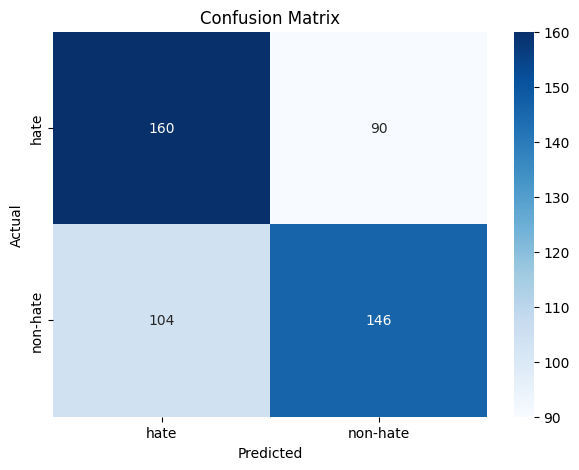

In [77]:
cfm = confusion_matrix(test_labels_encoded, test_predictions)
classes = np.unique(test_labels_encoded)

# Create DataFrame for confusion matrix
df_cfm = pd.DataFrame(cfm, index=classes, columns=classes)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
cfm_plot = sns.heatmap(df_cfm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### random forest

In [78]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
class_weight = {0: class_weights[0], 1: class_weights[1]}
rf_model = RandomForestClassifier(class_weight=class_weight, n_estimators=100, random_state=42)
rf_model.fit(train_embeddings, train_labels_encoded)

# Make predictions for the entire test set
rf_test_predictions = rf_model.predict(test_embeddings)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(test_labels_encoded, rf_test_predictions)
rf_recall = recall_score(test_labels_encoded, rf_test_predictions, average="macro")
rf_precision = precision_score(test_labels_encoded, rf_test_predictions, average="macro")
rf_f1 = f1_score(test_labels_encoded, rf_test_predictions, average="macro")

print("Random Forest Evaluation scores:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

# Classification Report
rf_classification_rep = classification_report(test_labels_encoded, rf_test_predictions, labels=np.unique(test_labels_encoded), target_names=target_names)
print("Random Forest Classification Report:")
print(rf_classification_rep)

# Save Random Forest predictions to a CSV file
rf_predictions = list(le.inverse_transform(rf_test_predictions))
rf_classified_df = pd.DataFrame({'tweets': test_sentences, 'actual_label': test_labels, 'predicted_label': rf_predictions})
rf_classified_df.to_csv('RandomForest_predictions.csv', index=False)
print("Random Forest Predictions saved to 'RandomForest_predictions.csv'")


Random Forest Evaluation scores:
Accuracy: 0.54
Precision: 0.5401258346173601
Recall: 0.54
F1 Score: 0.5396390770363966
Random Forest Classification Report:
              precision    recall  f1-score   support

        hate       0.54      0.51      0.53       250
    non-hate       0.54      0.57      0.55       250

    accuracy                           0.54       500
   macro avg       0.54      0.54      0.54       500
weighted avg       0.54      0.54      0.54       500

Random Forest Predictions saved to 'RandomForest_predictions.csv'


### confusion matrix

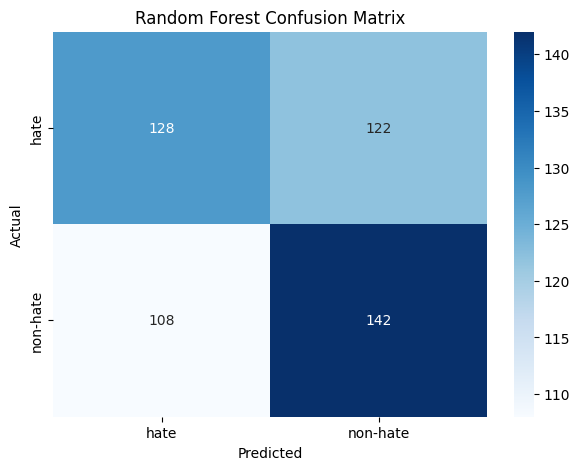

In [79]:
# Confusion Matrix for Random Forest
rf_cfm = confusion_matrix(test_labels_encoded, rf_test_predictions)
rf_classes = np.unique(test_labels_encoded)

rf_df_cfm = pd.DataFrame(rf_cfm, index=rf_classes, columns=rf_classes)
plt.figure(figsize=(7, 5))
rf_cfm_plot = sns.heatmap(rf_df_cfm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### XGBOOST

In [80]:
from xgboost import XGBClassifier

# Train XGBoost model
xgb_model = XGBClassifier(scale_pos_weight=class_weights[1]/class_weights[0], random_state=42)
xgb_model.fit(train_embeddings, train_labels_encoded)

# Make predictions for the entire test set
xgb_test_predictions = xgb_model.predict(test_embeddings)

# Evaluate the XGBoost model
xgb_accuracy = accuracy_score(test_labels_encoded, xgb_test_predictions)
xgb_recall = recall_score(test_labels_encoded, xgb_test_predictions, average="macro")
xgb_precision = precision_score(test_labels_encoded, xgb_test_predictions, average="macro")
xgb_f1 = f1_score(test_labels_encoded, xgb_test_predictions, average="macro")

print("XGBoost Evaluation scores:")
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1 Score:", xgb_f1)

# Classification Report for XGBoost
xgb_target_names = ['hate', 'non-hate']
xgb_classification_rep = classification_report(test_labels_encoded, xgb_test_predictions, labels=np.unique(test_labels_encoded), target_names=xgb_target_names)
print("XGBoost Classification Report:")
print(xgb_classification_rep)

# Save XGBoost predictions to a CSV file
xgb_predictions = list(le.inverse_transform(xgb_test_predictions))
xgb_classified_df = pd.DataFrame({'tweets': test_sentences, 'actual_label': test_labels, 'predicted_label': xgb_predictions})
xgb_classified_df.to_csv('XGBoost_predictions.csv', index=False)
print("XGBoost Predictions saved to 'XGBoost_predictions.csv'")


XGBoost Evaluation scores:
Accuracy: 0.616
Precision: 0.6161189057594978
Recall: 0.616
F1 Score: 0.6159016708277318
XGBoost Classification Report:
              precision    recall  f1-score   support

        hate       0.61      0.63      0.62       250
    non-hate       0.62      0.60      0.61       250

    accuracy                           0.62       500
   macro avg       0.62      0.62      0.62       500
weighted avg       0.62      0.62      0.62       500

XGBoost Predictions saved to 'XGBoost_predictions.csv'


### confusion matrix

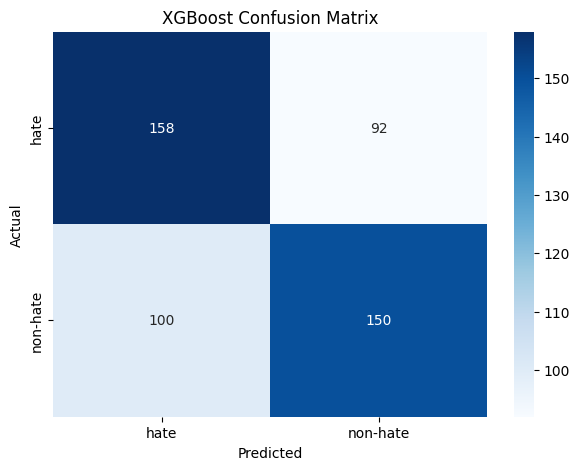

In [81]:
# Confusion Matrix for XGBoost
xgb_cfm = confusion_matrix(test_labels_encoded, xgb_test_predictions)
xgb_classes = np.unique(test_labels_encoded)

xgb_df_cfm = pd.DataFrame(xgb_cfm, index=xgb_classes, columns=xgb_classes)
plt.figure(figsize=(7, 5))
xgb_cfm_plot = sn.heatmap(xgb_df_cfm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### SVM

In [82]:
from sklearn.svm import SVC

# Train SVM model
svm_model = SVC(class_weight=class_weight, random_state=42)
svm_model.fit(train_embeddings, train_labels_encoded)

# Make predictions for the entire test set
svm_test_predictions = svm_model.predict(test_embeddings)

# Evaluate the SVM model
svm_accuracy = accuracy_score(test_labels_encoded, svm_test_predictions)
svm_recall = recall_score(test_labels_encoded, svm_test_predictions, average="macro")
svm_precision = precision_score(test_labels_encoded, svm_test_predictions, average="macro")
svm_f1 = f1_score(test_labels_encoded, svm_test_predictions, average="macro")

print("SVM Evaluation scores:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1 Score:", svm_f1)

# Classification Report for SVM
svm_target_names = ['hate', 'non-hate']
svm_classification_rep = classification_report(test_labels_encoded, svm_test_predictions, labels=np.unique(test_labels_encoded), target_names=svm_target_names)
print("SVM Classification Report:")
print(svm_classification_rep)

# Save SVM predictions to a CSV file
svm_predictions = list(le.inverse_transform(svm_test_predictions))
svm_classified_df = pd.DataFrame({'tweets': test_sentences, 'actual_label': test_labels, 'predicted_label': svm_predictions})
svm_classified_df.to_csv('SVM_predictions.csv', index=False)
print("SVM Predictions saved to 'SVM_predictions.csv'")


SVM Evaluation scores:
Accuracy: 0.57
Precision: 0.5707070707070707
Recall: 0.5700000000000001
F1 Score: 0.568922305764411
SVM Classification Report:
              precision    recall  f1-score   support

        hate       0.56      0.62      0.59       250
    non-hate       0.58      0.52      0.55       250

    accuracy                           0.57       500
   macro avg       0.57      0.57      0.57       500
weighted avg       0.57      0.57      0.57       500

SVM Predictions saved to 'SVM_predictions.csv'


### confusion matrix

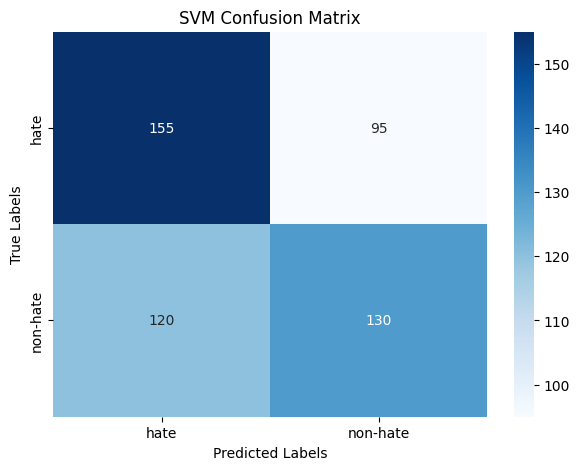

In [83]:
# Calculate the confusion matrix
svm_cfm = confusion_matrix(test_labels_encoded, svm_test_predictions)
classes = np.unique(test_labels_encoded)

# Create a DataFrame for the confusion matrix
df_svm_cfm = pd.DataFrame(svm_cfm, index=classes, columns=classes)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
svm_cfm_plot = sn.heatmap(df_svm_cfm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### KNN

In [84]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(train_embeddings, train_labels_encoded)

# Make predictions for the entire test set
knn_test_predictions = knn_model.predict(test_embeddings)

# Evaluate the KNN model
knn_accuracy = accuracy_score(test_labels_encoded, knn_test_predictions)
knn_recall = recall_score(test_labels_encoded, knn_test_predictions, average="macro")
knn_precision = precision_score(test_labels_encoded, knn_test_predictions, average="macro")
knn_f1 = f1_score(test_labels_encoded, knn_test_predictions, average="macro")

print("KNN Evaluation scores:")
print("Accuracy:", knn_accuracy)
print("Precision:", knn_precision)
print("Recall:", knn_recall)
print("F1 Score:", knn_f1)

# Classification Report for KNN
knn_target_names = ['hate', 'non-hate']
knn_classification_rep = classification_report(test_labels_encoded, knn_test_predictions, labels=np.unique(test_labels_encoded), target_names=knn_target_names)
print("KNN Classification Report:")
print(knn_classification_rep)

# Save KNN predictions to a CSV file
knn_predictions = list(le.inverse_transform(knn_test_predictions))
knn_classified_df = pd.DataFrame({'tweets': test_sentences, 'actual_label': test_labels, 'predicted_label': knn_predictions})
knn_classified_df.to_csv('KNN_predictions.csv', index=False)
print("KNN Predictions saved to 'KNN_predictions.csv'")


KNN Evaluation scores:
Accuracy: 0.54
Precision: 0.540847003463826
Recall: 0.54
F1 Score: 0.537602933607823
KNN Classification Report:
              precision    recall  f1-score   support

        hate       0.53      0.61      0.57       250
    non-hate       0.55      0.47      0.50       250

    accuracy                           0.54       500
   macro avg       0.54      0.54      0.54       500
weighted avg       0.54      0.54      0.54       500

KNN Predictions saved to 'KNN_predictions.csv'


### confusion matrix

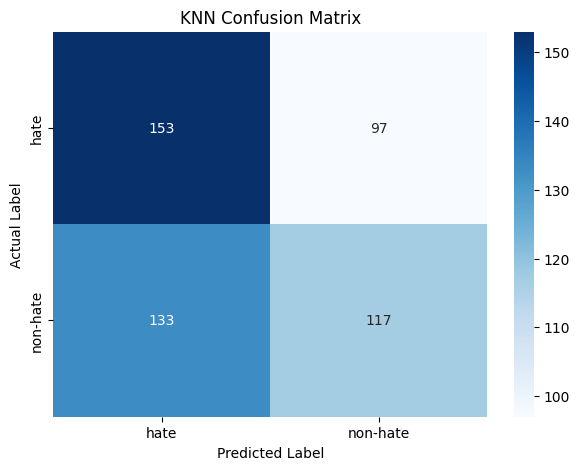

In [85]:
# Generate confusion matrix for KNN
knn_cfm = confusion_matrix(test_labels_encoded, knn_test_predictions)
knn_classes = np.unique(test_labels_encoded)

# Create a DataFrame for confusion matrix
knn_df_cfm = pd.DataFrame(knn_cfm, index=knn_classes, columns=knn_classes)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
knn_cfm_plot = sn.heatmap(knn_df_cfm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

### Decision tree

In [86]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree model
dt_model = DecisionTreeClassifier(class_weight=class_weight, random_state=42)
dt_model.fit(train_embeddings, train_labels_encoded)

# Make predictions for the entire test set
dt_test_predictions = dt_model.predict(test_embeddings)

# Evaluate the Decision Tree model
dt_accuracy = accuracy_score(test_labels_encoded, dt_test_predictions)
dt_recall = recall_score(test_labels_encoded, dt_test_predictions, average="macro")
dt_precision = precision_score(test_labels_encoded, dt_test_predictions, average="macro")
dt_f1 = f1_score(test_labels_encoded, dt_test_predictions, average="macro")

print("Decision Tree Evaluation scores:")
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)

# Classification Report for Decision Tree
dt_target_names = ['hate', 'non-hate']
dt_classification_rep = classification_report(test_labels_encoded, dt_test_predictions, labels=np.unique(test_labels_encoded), target_names=dt_target_names)
print("Decision Tree Classification Report:")
print(dt_classification_rep)

# Save Decision Tree predictions to a CSV file
dt_predictions = list(le.inverse_transform(dt_test_predictions))
dt_classified_df = pd.DataFrame({'tweets': test_sentences, 'actual_label': test_labels, 'predicted_label': dt_predictions})
dt_classified_df.to_csv('DecisionTree_predictions.csv', index=False)
print("Decision Tree Predictions saved to 'DecisionTree_predictions.csv'")


Decision Tree Evaluation scores:
Accuracy: 0.604
Precision: 0.6040599385245902
Recall: 0.604
F1 Score: 0.6039429677873613
Decision Tree Classification Report:
              precision    recall  f1-score   support

        hate       0.60      0.62      0.61       250
    non-hate       0.61      0.59      0.60       250

    accuracy                           0.60       500
   macro avg       0.60      0.60      0.60       500
weighted avg       0.60      0.60      0.60       500

Decision Tree Predictions saved to 'DecisionTree_predictions.csv'


### confusion matrix

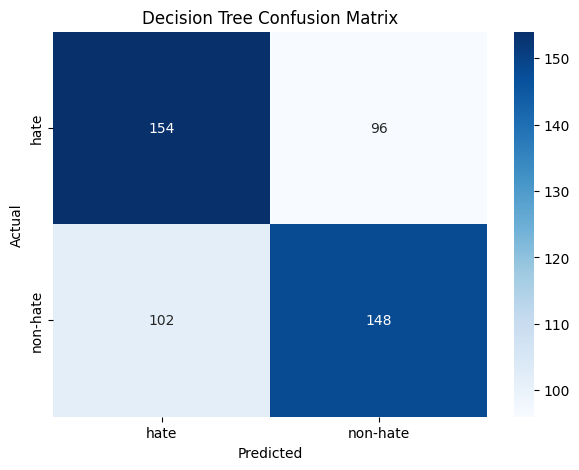

In [87]:
# Confusion matrix for Decision Tree
dt_cfm = confusion_matrix(test_labels_encoded, dt_test_predictions)
dt_classes = np.unique(train_labels_encoded)

# Create a DataFrame for the confusion matrix
dt_df_cfm = pd.DataFrame(dt_cfm, index=dt_classes, columns=dt_classes)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
dt_cfm_plot = sn.heatmap(dt_df_cfm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Ada boost

In [88]:
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost model
adaboost_model = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_model.fit(train_embeddings, train_labels_encoded)

# Make predictions for the entire test set
adaboost_test_predictions = adaboost_model.predict(test_embeddings)

# Evaluate the AdaBoost model
adaboost_accuracy = accuracy_score(test_labels_encoded, adaboost_test_predictions)
adaboost_recall = recall_score(test_labels_encoded, adaboost_test_predictions, average="macro")
adaboost_precision = precision_score(test_labels_encoded, adaboost_test_predictions, average="macro")
adaboost_f1 = f1_score(test_labels_encoded, adaboost_test_predictions, average="macro")

print("AdaBoost Evaluation scores:")
print("Accuracy:", adaboost_accuracy)
print("Precision:", adaboost_precision)
print("Recall:", adaboost_recall)
print("F1 Score:", adaboost_f1)

# Classification Report for AdaBoost
adaboost_target_names = ['hate', 'non-hate']
adaboost_classification_rep = classification_report(test_labels_encoded, adaboost_test_predictions, labels=np.unique(test_labels_encoded), target_names=adaboost_target_names)
print("AdaBoost Classification Report:")
print(adaboost_classification_rep)

# Save AdaBoost predictions to a CSV file
adaboost_predictions = list(le.inverse_transform(adaboost_test_predictions))
adaboost_classified_df = pd.DataFrame({'tweets': test_sentences, 'actual_label': test_labels, 'predicted_label': adaboost_predictions})
adaboost_classified_df.to_csv('AdaBoost_predictions.csv', index=False)
print("AdaBoost Predictions saved to 'AdaBoost_predictions.csv'")


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Evaluation scores:
Accuracy: 0.548
Precision: 0.5482501286670098
Recall: 0.548
F1 Score: 0.5474134478283856
AdaBoost Classification Report:
              precision    recall  f1-score   support

        hate       0.54      0.58      0.56       250
    non-hate       0.55      0.51      0.53       250

    accuracy                           0.55       500
   macro avg       0.55      0.55      0.55       500
weighted avg       0.55      0.55      0.55       500

AdaBoost Predictions saved to 'AdaBoost_predictions.csv'


### confusion matrix

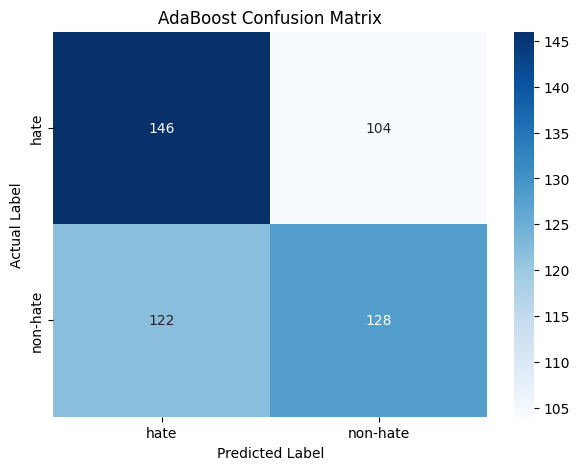

In [89]:
# Generate confusion matrix for AdaBoost
adaboost_cfm = confusion_matrix(test_labels_encoded, adaboost_test_predictions)
adaboost_classes = np.unique(test_labels_encoded)

# Create a DataFrame for the confusion matrix
adaboost_df_cfm = pd.DataFrame(adaboost_cfm, index=adaboost_classes, columns=adaboost_classes)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
adaboost_cfm_plot = sn.heatmap(adaboost_df_cfm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("AdaBoost Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

### Naive bayes

In [90]:
from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_labels_encoded)

# Make predictions for the entire test set
nb_test_predictions = nb_model.predict(test_embeddings)

# Evaluate the Naive Bayes model
nb_accuracy = accuracy_score(test_labels_encoded, nb_test_predictions)
nb_recall = recall_score(test_labels_encoded, nb_test_predictions, average="macro")
nb_precision = precision_score(test_labels_encoded, nb_test_predictions, average="macro")
nb_f1 = f1_score(test_labels_encoded, nb_test_predictions, average="macro")

print("Naive Bayes Evaluation scores:")
print("Accuracy:", nb_accuracy)
print("Precision:", nb_precision)
print("Recall:", nb_recall)
print("F1 Score:", nb_f1)

# Classification Report for Naive Bayes
nb_target_names = ['hate', 'non-hate']
nb_classification_rep = classification_report(test_labels_encoded, nb_test_predictions, labels=np.unique(test_labels_encoded), target_names=nb_target_names)
print("Naive Bayes Classification Report:")
print(nb_classification_rep)

# Save Naive Bayes predictions to a CSV file
nb_predictions = list(le.inverse_transform(nb_test_predictions))
nb_classified_df = pd.DataFrame({'tweets': test_sentences, 'actual_label': test_labels, 'predicted_label': nb_predictions})
nb_classified_df.to_csv('NaiveBayes_predictions.csv', index=False)
print("Naive Bayes Predictions saved to 'NaiveBayes_predictions.csv'")


Naive Bayes Evaluation scores:
Accuracy: 0.368
Precision: 0.36520488856937455
Recall: 0.368
F1 Score: 0.36470663921770463
Naive Bayes Classification Report:
              precision    recall  f1-score   support

        hate       0.35      0.30      0.32       250
    non-hate       0.38      0.44      0.41       250

    accuracy                           0.37       500
   macro avg       0.37      0.37      0.36       500
weighted avg       0.37      0.37      0.36       500

Naive Bayes Predictions saved to 'NaiveBayes_predictions.csv'


### confusion matrix

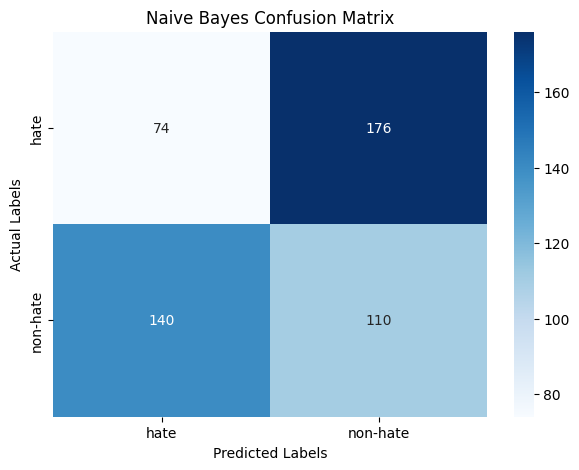

In [91]:
# Confusion Matrix for Naive Bayes
nb_cfm = confusion_matrix(test_labels_encoded, nb_test_predictions)
nb_classes = np.unique(train_labels_encoded)

# Create a DataFrame for the Confusion Matrix
nb_df_cfm = pd.DataFrame(nb_cfm, index=nb_classes, columns=nb_classes)

# Plot the Confusion Matrix
plt.figure(figsize=(7, 5))
nb_cfm_plot = sn.heatmap(nb_df_cfm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

### svm rbf

In [92]:
from sklearn.svm import SVC

# Train SVM model
svm_model = SVC(kernel='linear', class_weight=class_weight, random_state=42)
svm_model.fit(train_embeddings, train_labels_encoded)

# Make predictions for the entire test set
svm_test_predictions = svm_model.predict(test_embeddings)

# Evaluate the SVM model
svm_accuracy = accuracy_score(test_labels_encoded, svm_test_predictions)
svm_recall = recall_score(test_labels_encoded, svm_test_predictions, average="macro")
svm_precision = precision_score(test_labels_encoded, svm_test_predictions, average="macro")
svm_f1 = f1_score(test_labels_encoded, svm_test_predictions, average="macro")

print("SVM Evaluation scores:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1 Score:", svm_f1)

# Classification Report for SVM
svm_target_names = ['hate', 'non-hate']
svm_classification_rep = classification_report(test_labels_encoded, svm_test_predictions, labels=np.unique(test_labels_encoded), target_names=svm_target_names)
print("SVM Classification Report:")
print(svm_classification_rep)

# Save SVM predictions to a CSV file
svm_predictions = list(le.inverse_transform(svm_test_predictions))
svm_classified_df = pd.DataFrame({'tweets': test_sentences, 'actual_label': test_labels, 'predicted_label': svm_predictions})
svm_classified_df.to_csv('SVM_linear_predictions.csv', index=False)
print("SVM Predictions saved to 'SVM_linear_predictions.csv'")


SVM Evaluation scores:
Accuracy: 0.598
Precision: 0.5980768922835503
Recall: 0.598
F1 Score: 0.5979211925537405
SVM Classification Report:
              precision    recall  f1-score   support

        hate       0.60      0.61      0.60       250
    non-hate       0.60      0.58      0.59       250

    accuracy                           0.60       500
   macro avg       0.60      0.60      0.60       500
weighted avg       0.60      0.60      0.60       500

SVM Predictions saved to 'SVM_linear_predictions.csv'
